In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
re=6378100

In [3]:
coords=pd.read_csv("/home/mohan/coords.csv")

In [4]:
xyz=np.zeros(coords.shape)
xyz[:,0] = np.cos(np.deg2rad(coords['lat']))*np.cos(np.deg2rad(coords['lon']))
xyz[:,1] = np.cos(np.deg2rad(coords['lat']))*np.sin(np.deg2rad(coords['lon']))
xyz[:,2] = np.sin(np.deg2rad(coords['lat']))

In [ ]:
plt.scatter(xyz[:,0]*re/1e3,xyz[:,1]*re/1e3)

In [5]:
N=xyz.shape[0]
east=[0,1,0]
zen = np.mean(xyz,axis=0)
north=np.cross(zen,east)

proj_mat = np.vstack([east,north,zen]).T

nb = N*(N-1)//2

print("Num baselines = ", nb)

uvw=np.zeros((nb,3))
xyz[:]=xyz*re
count=0
for i in range(N):
    for j in range(i+1,N):
        uvw[count,:] = xyz[i,:]-xyz[j,:] #Baselines in m, in Earth Center ref frame. will project later
        count+=1
print(f"Max baseline for array is {np.max(np.sqrt(np.sum(uvw**2,axis=1))):4.2f} m")
# uvw=np.vstack([uvw,-uvw])*freq/3e8
print(uvw)

Num baselines =  45
Max baseline for array is 23952.35 m
[[  -774.30160486   8146.25834852   1501.89958454]
 [  5086.27461788  12169.11988978   2265.33780797]
 [ -3474.86568538   6151.07801287   1126.68915597]
 [ -1201.33491377  10068.30420488   1857.29685864]
 [  -817.28197215   5245.19013886    965.00424205]
 [ 10758.09813146   5912.51267608   1126.68915597]
 [ -5553.2634047   22909.64881803   4245.49101548]
 [ -2515.29427652  12280.49595908   2265.33780797]
 [  3833.49008182  17479.11508585   3250.93567122]
 [  5860.57622274   4022.86154125    763.43822342]
 [ -2700.56408053  -1995.18033566   -375.21042858]
 [  -427.03330892   1922.04585635    355.3972741 ]
 [   -42.98036729  -2901.06820966   -536.8953425 ]
 [ 11532.39973632  -2233.74567245   -375.21042858]
 [ -4778.96179984  14763.39046951   2743.59143094]
 [ -1740.99267166   4134.23761056    763.43822342]
 [  4607.79168668   9332.85673733   1749.03608668]
 [ -8561.14030327  -6018.04187691  -1138.648652  ]
 [ -6287.60953166  -2100.

In [6]:
freq = np.linspace(3.5,7,101)*1e6
c=3e8
u=uvw[:,0]
v=uvw[:,1]
w=uvw[:,2]
# xx[:,1] = xx[:,1]+1
uu=np.outer(freq/c,u).flatten()
vv=np.outer(freq/c,v).flatten()
ww=np.outer(freq/c,w).flatten()
uvw=np.zeros((uu.shape[0],3))
uvw[:,0]=uu
uvw[:,1]=vv
uvw[:,2]=ww



In [7]:
uvw = np.vstack([uvw,-uvw])
uvw_local = uvw@proj_mat

In [ ]:
uvw_local

In [27]:
def grid_uv(uv,res,npix):
    
    #
    fov = res*npix
    delu = 1/fov
    
    # umax = 1/res since our resolution is smaller than what's needed for better plotting, we'll never reach npix
    # so no risk of exceeding array indices. Max uv will be around 830 as shown below
    
    S = np.zeros((npix,npix),dtype='float64')
    
#     print(delu)
    uv_int=np.round(uv/delu).astype(int)
#     uv_int=np.asarray(uv/delu,dtype='int')
    print(uv_int)
    for i in range(uv.shape[0]):
        S[uv_int[i,0],uv_int[i,1]] = S[uv_int[i,0],uv_int[i,1]] + 1   #rows are U, columns are V
    
    return S

In [9]:
# Array a
lm = 3e8/5e6 #m
res = lm/24000 #max baseline
fov = np.deg2rad(10)
print("Array A")
print(f"Synth. resol\t: {np.rad2deg(res)*3600:4.2f}\"\nFOV\t\t: {np.rad2deg(fov)*3600:4.2f}\"\nMax UV\t\t: {int(fov/res):d}")

#let's keep pixel resolution more than FWHM of synthesized image so we can see the FWHM clearly in the plot.
#this basically means max_npix >= max_u, so that we don't saturate the grid.

npix=2048
myres=fov/npix
print(f"Pixel resol \t: {np.rad2deg(myres)*3600:4.2f}\"")

Array A
Synth. resol	: 515.66"
FOV		: 36000.00"
Max UV		: 69
Pixel resol 	: 17.58"


In [17]:
np.rad2deg(myres)*60

0.29296875

In [ ]:
np.max(uvw_local[:,:2])*fov

In [ ]:
uvw_local[:,:2]

In [28]:
uv_grid = grid_uv(uvw_local[:,:2],myres,npix)

[[ 17   2]
 [ 25 -10]
 [ 13   7]
 ...
 [ 43  12]
 [ 22  38]
 [-21  25]]


In [ ]:
x,y=np.where(uv_grid[:2048,:2048]!=0)

In [29]:
img = np.real(np.fft.fft2(uv_grid))
img=img/img.max()

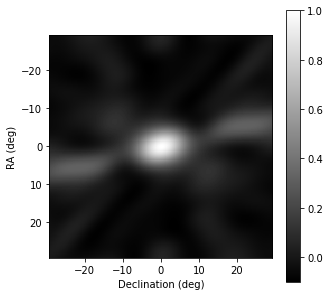

In [33]:
f=plt.gcf()
f.set_size_inches(5,5)
plt.clf();
w=100
x0=img.shape[0]//2
pixres = np.rad2deg(myres)*60
myext = [-w*pixres,w*pixres,w*pixres,-w*pixres]
plt.imshow(np.fft.fftshift(img)[x0-w:x0+w,x0-w:x0+w],extent=myext,interpolation='none',cmap='gray')
plt.xlabel("Declination (deg)")
plt.ylabel("RA (deg)")
plt.colorbar()
# plt.xlim()
# plt.ylim(x0-25,x0+25)

In [26]:
uv_grid.shape

(4096, 4096)

In [ ]:
f=plt.gcf()
f.set_size_inches(10,4)
xx=np.fft.fftshift(img)[x0-50:x0+50,x0].copy()
xx=xx/xx.max()
plt.subplot(121)
plt.plot(xx)
plt.title("RA")
mygauss = lambda x,amp,mu,sig: amp*np.exp(-0.5*(x-mu)**2/sig**2)
fitp,cov=curve_fit(mygauss,np.arange(0,100),xx,[1,50,10])
print(f"FWHM along RA {np.rad2deg(fitp[2]*2.355*myres)*60:4.2f} arcmin")

xx=np.fft.fftshift(img)[x0,x0-50:x0+50].copy()
xx=xx/xx.max()
plt.subplot(122)
plt.plot(xx)
plt.title("Declination")
mygauss = lambda x,amp,mu,sig: amp*np.exp(-0.5*(x-mu)**2/sig**2)
fitp,cov=curve_fit(mygauss,np.arange(0,100),xx,[1,50,10])
print(f"FWHM along dec {np.rad2deg(fitp[2]*myres)*60:4.2f} arcmin")

### VLA website states that in case of natural weighting (all visiblities having the same weight, as is the case here), FWHM must be multiplied by 1.5.  https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/resolution

#### Stated FWHM = 1.3''. Therefore, for natural weighting we expect FWHM ~ 1.95''. Thus, approximately, the my FWHM matches very well with what's stated on the website.

### Rotation synthesis

Zenith

In [ ]:
t=np.linspace(-4,4,51)
phi = t*np.pi/12
#2*pi in 24 hrs.
xyz,uvw,proj_mat=get_uvw(arr='a')

nn=uvw.shape[0]
uv_big = np.zeros((nn*t.shape[0],3))
for i,p in enumerate(phi):
    rot_mat = np.asarray([[np.cos(p),-np.sin(p),0],[np.sin(p),np.cos(p),0],[0,0,1]]).T 
    #our vectors are rows, so taking a Transpose. Result is same as what Jon uses.
    uv_big[i*nn:(i+1)*nn,:] = uvw@rot_mat
print(uv_big.shape)
uv_big[:] = uv_big@proj_mat

In [ ]:
uv_grid = grid_uv(uv_big[:,:2],myres,npix)
img = np.abs(np.fft.ifft2(uv_grid))**2
f=plt.gcf()
f.set_size_inches(10,5)

plt.subplot(121)
plt.scatter(uv_big[:,0],uv_big[:,1])
plt.title("A array, 8 hrs UV coverage, zenith")
plt.xlabel('v')
plt.ylabel('u')

plt.subplot(122)
w=25
x0=img.shape[0]//2
plt.imshow(np.fft.fftshift(img)[x0-w:x0+w,x0-w:x0+w],interpolation='none')
plt.title("Source at zenith")

plt.tight_layout()
# plt.xlim()
# plt.ylim(x0-25,x0+25)

In [ ]:
t=np.linspace(-4,4,51)
phi = t*np.pi/12
#2*pi in 24 hrs.
xyz,uvw,proj_mat=get_uvw(arr='a',decl=np.pi/2)

nn=uvw.shape[0]
uv_big = np.zeros((nn*t.shape[0],3))
for i,p in enumerate(phi):
    rot_mat = np.asarray([[np.cos(p),-np.sin(p),0],[np.sin(p),np.cos(p),0],[0,0,1]]).T 
    #our vectors are rows, so taking a Transpose. Result is same as what Jon uses.
    uv_big[i*nn:(i+1)*nn,:] = uvw@rot_mat # uvw are baselines in Earth's center frame. applying the rotation matrix.
print(uv_big.shape)
uv_big[:] = uv_big@proj_mat  #projecting to source' frame for true UVW

uv_grid = grid_uv(uv_big[:,:2],myres,npix)
img = np.abs(np.fft.ifft2(uv_grid))**2
f=plt.gcf()
f.set_size_inches(10,5)

plt.subplot(121)
plt.scatter(uv_big[:,0],uv_big[:,1])
plt.title("A array, 8 hrs UV coverage, North Celestial Pole")
plt.xlabel('v')
plt.ylabel('u')

plt.subplot(122)
w=25
x0=img.shape[0]//2
plt.imshow(np.fft.fftshift(img)[x0-w:x0+w,x0-w:x0+w],interpolation='none')
plt.title("Source at NCP")

plt.tight_layout()
# plt.xlim()
# plt.ylim(x0-25,x0+25)

In [ ]:
t=np.linspace(-4,4,51)
phi = t*np.pi/12
#2*pi in 24 hrs.
xyz,uvw,proj_mat=get_uvw(arr='a',decl=0)

nn=uvw.shape[0]
uv_big = np.zeros((nn*t.shape[0],3))
for i,p in enumerate(phi):
    rot_mat = np.asarray([[np.cos(p),-np.sin(p),0],[np.sin(p),np.cos(p),0],[0,0,1]]).T 
    #our vectors are rows, so taking a Transpose. Result is same as what Jon uses.
    uv_big[i*nn:(i+1)*nn,:] = uvw@rot_mat
print(uv_big.shape)
uv_big[:] = uv_big@proj_mat

uv_grid = grid_uv(uv_big[:,:2],myres,npix)
img = np.abs(np.fft.ifft2(uv_grid))**2
f=plt.gcf()
f.set_size_inches(10,5)

plt.subplot(121)
plt.scatter(uv_big[:,0],uv_big[:,1])
plt.title("A array, 8 hrs UV coverage, Equator")
plt.xlabel('v')
plt.ylabel('u')

plt.subplot(122)
w=25
x0=img.shape[0]//2
plt.imshow(np.fft.fftshift(img)[x0-w:x0+w,x0-w:x0+w],interpolation='none')
plt.title("Source at Equator")

plt.tight_layout()
# plt.xlim()
# plt.ylim(x0-25,x0+25)